# Предсказания победителя в онлайн-игре Dota 2

Организуем загрузку обучающих данных в датафрейм; в качестве индекса будет выступать колонка 'match_id':

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import datetime

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler

In [2]:
features = pd.read_csv('D:/Downloads/features.csv', index_col='match_id')
print(features.shape)
features.head()

(97230, 108)


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


Считаем количество пропущенных значений для каждого признака

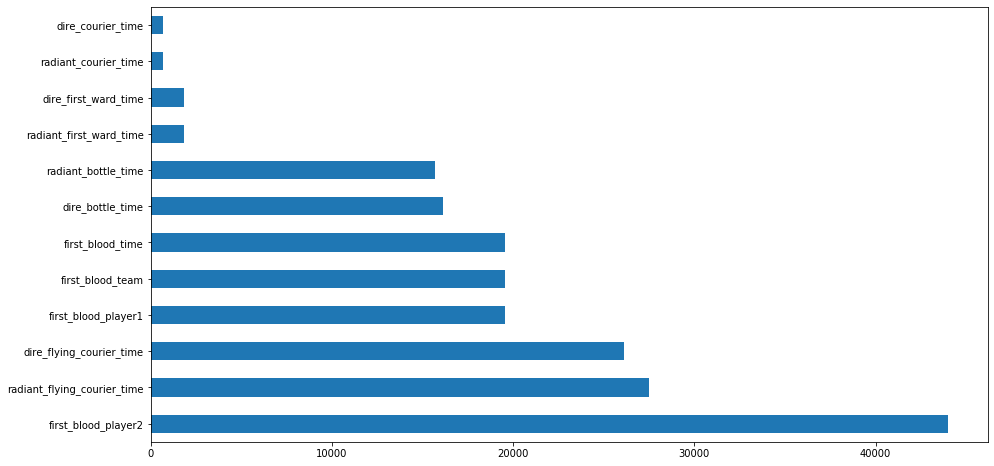

In [3]:
null_features = features.isnull().sum()
null_features = null_features[null_features > 0].sort_values(ascending=False)
null_features.plot.barh(figsize=(15,8));

В нашем наборе данных имеется 12 призаков, которые имеют пустые значения. Больше всего пропусков связано с событиями "первая кровь" (first blood) и временем приобретения предмета "courier"/"flying_courier".

Очевидно, что значения пропущенны по причине того, что в некоторых матчачх событие "первая кровь" наступила после пятой минуты, "flying_courier" был приобретен так же позднее 5 минуты.

In [4]:
features.fillna(0, inplace=True)

In [5]:
future_feature = [
    'duration',
    'radiant_win', 
    'tower_status_radiant', 
    'tower_status_dire',
    'barracks_status_radiant', 
    'barracks_status_dire'
]

features.columns

Index(['start_time', 'lobby_type', 'r1_hero', 'r1_level', 'r1_xp', 'r1_gold',
       'r1_lh', 'r1_kills', 'r1_deaths', 'r1_items',
       ...
       'dire_boots_count', 'dire_ward_observer_count',
       'dire_ward_sentry_count', 'dire_first_ward_time', 'duration',
       'radiant_win', 'tower_status_radiant', 'tower_status_dire',
       'barracks_status_radiant', 'barracks_status_dire'],
      dtype='object', length=108)

In [6]:
labels = features['radiant_win']
data = features.drop(future_feature, axis=1)

В качестве целевой переменной будет выступать признак 'radiant_win'(1, если победила команда Radiant, 0 — иначе). Кроме того, необходимо удалить признаки, которые относятся к итогам матча, так как они будут отсутсвовать в тестовом наборе данных

## Градиентный бустинг

In [7]:
fold = KFold(shuffle=True, n_splits=5, random_state=42)
scores_gb = []

N = [10, 20, 30, 50, 100, 150, 200]

for n in N[:3]:
    gb_model = GradientBoostingClassifier(n_estimators=n)
    
    start_time = datetime.datetime.now()
    score_gb = cross_val_score(gb_model, data, labels, cv=fold, scoring='roc_auc', n_jobs=-1)
    
    scores_gb.append(score_gb.mean())
   
    print('Time elapsed for {0} estimators: {1}'.format(n, datetime.datetime.now() - start_time))
    print('Score GB: ', score_gb)
    

Time elapsed for 10 estimators: 0:00:08.518927
Score GB:  [0.66383799 0.66635457 0.66360048 0.66529818 0.66516222]
Time elapsed for 20 estimators: 0:00:13.490606
Score GB:  [0.68083889 0.68272733 0.67969876 0.6834932  0.6855512 ]
Time elapsed for 30 estimators: 0:00:19.374459
Score GB:  [0.68892093 0.68934663 0.68712298 0.69180598 0.69283583]


Text(0, 0.5, 'Mean cross_val_score')

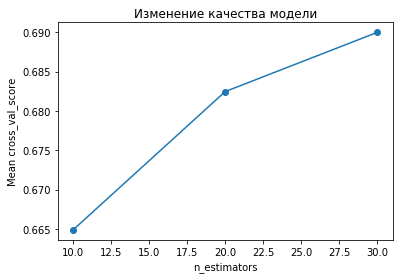

In [9]:
plt.plot(N[:3], scores_gb, marker='o')
plt.title('Изменение качества модели')
plt.xlabel('n_estimators')
plt.ylabel('Mean cross_val_score')

На графике видно, что дальнейшее увеличение числа деревьев может повысить качество модели. Имеет смысл продолжить увеличивать количество деревьев. Время обучения для 30 деревьев составило 18 секунд, при услвоии использования всех ресурсов процессора. Возможно имеет смысл уменьшить глубину деревьев до 2 для увеличения скорости обучения. 

In [10]:
for n in N[3:]:
    gb_model = GradientBoostingClassifier(n_estimators=n, max_depth=2, random_state=42)
    
    start_time = datetime.datetime.now()
    score_gb = cross_val_score(gb_model, data, labels, cv=fold, scoring='roc_auc', n_jobs=-1)
    
    scores_gb.append(score_gb.mean())
   
    print('Time elapsed for {0} estimators: {1}'.format(n, datetime.datetime.now() - start_time))
    print('Score GB: ', score_gb)    

Time elapsed for 50 estimators: 0:00:17.322727
Score GB:  [0.69005448 0.69094812 0.688467   0.69265148 0.69486188]
Time elapsed for 100 estimators: 0:00:35.337858
Score GB:  [0.69952527 0.70086478 0.69861939 0.70326991 0.7036773 ]
Time elapsed for 150 estimators: 0:00:52.333212
Score GB:  [0.70424295 0.70622264 0.70368195 0.7077047  0.70897641]
Time elapsed for 200 estimators: 0:01:06.815250
Score GB:  [0.70746568 0.70901004 0.70667922 0.71055424 0.71142795]


Text(0, 0.5, 'Mean cross_val_score')

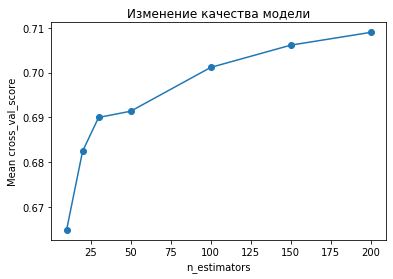

In [11]:
plt.plot(N, scores_gb, marker='o')
plt.title('Изменение качества модели')
plt.xlabel('n_estimators')
plt.ylabel('Mean cross_val_score')

## Логистическая регрессия

In [12]:
scaler = StandardScaler()

data_scaled = scaler.fit_transform(data)

D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Programs\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [13]:
scores_lr = []

C = [10**i for i in range(-3,4)]

for c in C:
    lr_model = LogisticRegression(C=c, random_state=42)
    
    start_time = datetime.datetime.now()
    score_lr = cross_val_score(lr_model, data_scaled, labels, cv=fold, scoring='roc_auc', n_jobs=-1)
    
    scores_lr.append(score_lr.mean())
   
    print('Time elapsed for c = {0} : {1}'.format(c, datetime.datetime.now() - start_time))
    print('Score LR: ', score_lr)

Time elapsed for c = 0.001 : 0:00:03.442253
Score LR:  [0.71449541 0.71577214 0.71625974 0.71697301 0.71831738]
Time elapsed for c = 0.01 : 0:00:04.003916
Score LR:  [0.71464598 0.71617915 0.71624749 0.71735041 0.71832832]
Time elapsed for c = 0.1 : 0:00:04.460349
Score LR:  [0.71462192 0.71617479 0.71619187 0.71737596 0.7182712 ]
Time elapsed for c = 1 : 0:00:04.378130
Score LR:  [0.71461815 0.71617185 0.71618338 0.7173762  0.71826341]
Time elapsed for c = 10 : 0:00:04.435749
Score LR:  [0.71461695 0.71617179 0.71618281 0.71737669 0.7182632 ]
Time elapsed for c = 100 : 0:00:04.373598
Score LR:  [0.71461692 0.71617206 0.71618249 0.71737655 0.71826345]
Time elapsed for c = 1000 : 0:00:04.478067
Score LR:  [0.71461693 0.71617214 0.7161825  0.71737659 0.71826346]


Text(0, 0.5, 'Mean cross_val_score')

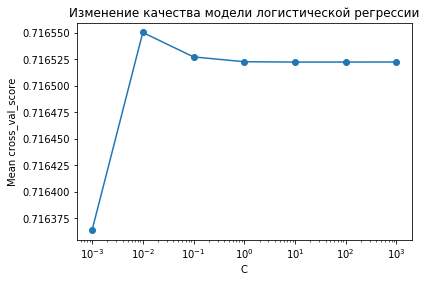

In [14]:
plt.xscale('log')
plt.plot(C, scores_lr, marker='o')
plt.title('Изменение качества модели логистической регрессии')
plt.xlabel('C')
plt.ylabel('Mean cross_val_score')

На графике видно, что максимум качества на кросс валидации достигается при кофициенте регуляризации равном 10^-2. При этом качество данной модели сопостивимо с качеством модели градиентного бустинга с большим числом деревьев. Скорость обучения при этом в 17 раз выше. 

In [15]:
cat_features = ['lobby_type']
for team in ['r', 'd']:
    for player in range(1,6):
        cat_features.append('{0}{1}_hero'.format(team, str(player)))

print(cat_features)

['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']


In [16]:
data_no_cat = data.drop(cat_features, axis=1)
data_no_cat = scaler.fit_transform(data_no_cat)

D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Programs\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [17]:
lr_model = LogisticRegression(C=0.01, random_state=42)
cross_val_score(lr_model, data_no_cat, labels, cv=fold, scoring='roc_auc', n_jobs=-1).mean()

0.7165593885630225

Удаление категориальных признаков никак не отразилось на качестве модели. Возможно, это связано с тем, что после маштабирования признаки практически не отличаются друг от друга и им назначаются небольшие весовые коофициенты.

In [18]:
lr_model = LogisticRegression(C=0.01, random_state=42)
lr_model.fit(data_scaled, labels)

D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
coef_df = pd.DataFrame(lr_model.coef_[0], index=data.columns, columns=['coef'])
coef_df.loc[pd.Index(cat_features)]

,coef
lobby_type,-0.005201
r1_hero,0.005502
r2_hero,-0.019787
r3_hero,0.002084
r4_hero,0.002415
r5_hero,-0.011294
d1_hero,0.000127
d2_hero,0.002674
d3_hero,-0.003449
d4_hero,0.006456


Действительно, эти коэффициенты очень малы

In [36]:
for feature in cat_features:
    print('{0} : {1} | max id: {2}'.format(feature, data[feature].nunique(), data[feature].unique().max()))

r1_hero : 108 | max id: 112
r2_hero : 108 | max id: 112
r3_hero : 108 | max id: 112
r4_hero : 108 | max id: 112
r5_hero : 108 | max id: 112
d1_hero : 108 | max id: 112
d2_hero : 108 | max id: 112
d3_hero : 108 | max id: 112
d4_hero : 108 | max id: 112
d5_hero : 108 | max id: 112


Все признаки, за исключесним признака 'lobby type' имеют длину 108, что соответствует количеству уникальных героев. Далее имеет смысл получить эти идентификаторы. Кроме того, наиболешее значение id героя не соответсвует числу 108: на это нужно будет обратитья внимание.

In [21]:
cat_features.remove('lobby_type')

id героя : [ 11  42  33  29  13   8  35  17  15  22  27  68  26  53  20  92  88 104
   3  73  72 110  36  58  91  50  71  30  25  39  19 101  94  51   7  75
  46  66  67  93  38  65  12  99  44  10  41  34 102  32  95  84  81  16
   6  96  43  79  47   1   2  63  97  80  54  83   5  60  77 112  21  69
  85  82  87  62  18  74  28  61  14  90  70  78  52  48  49   4  98  59
  56  86  37 100  23  57 106  40   9  76  31  64 109 103  55 105  89  45]
--------------------------------------------------------------------------------------------------------------


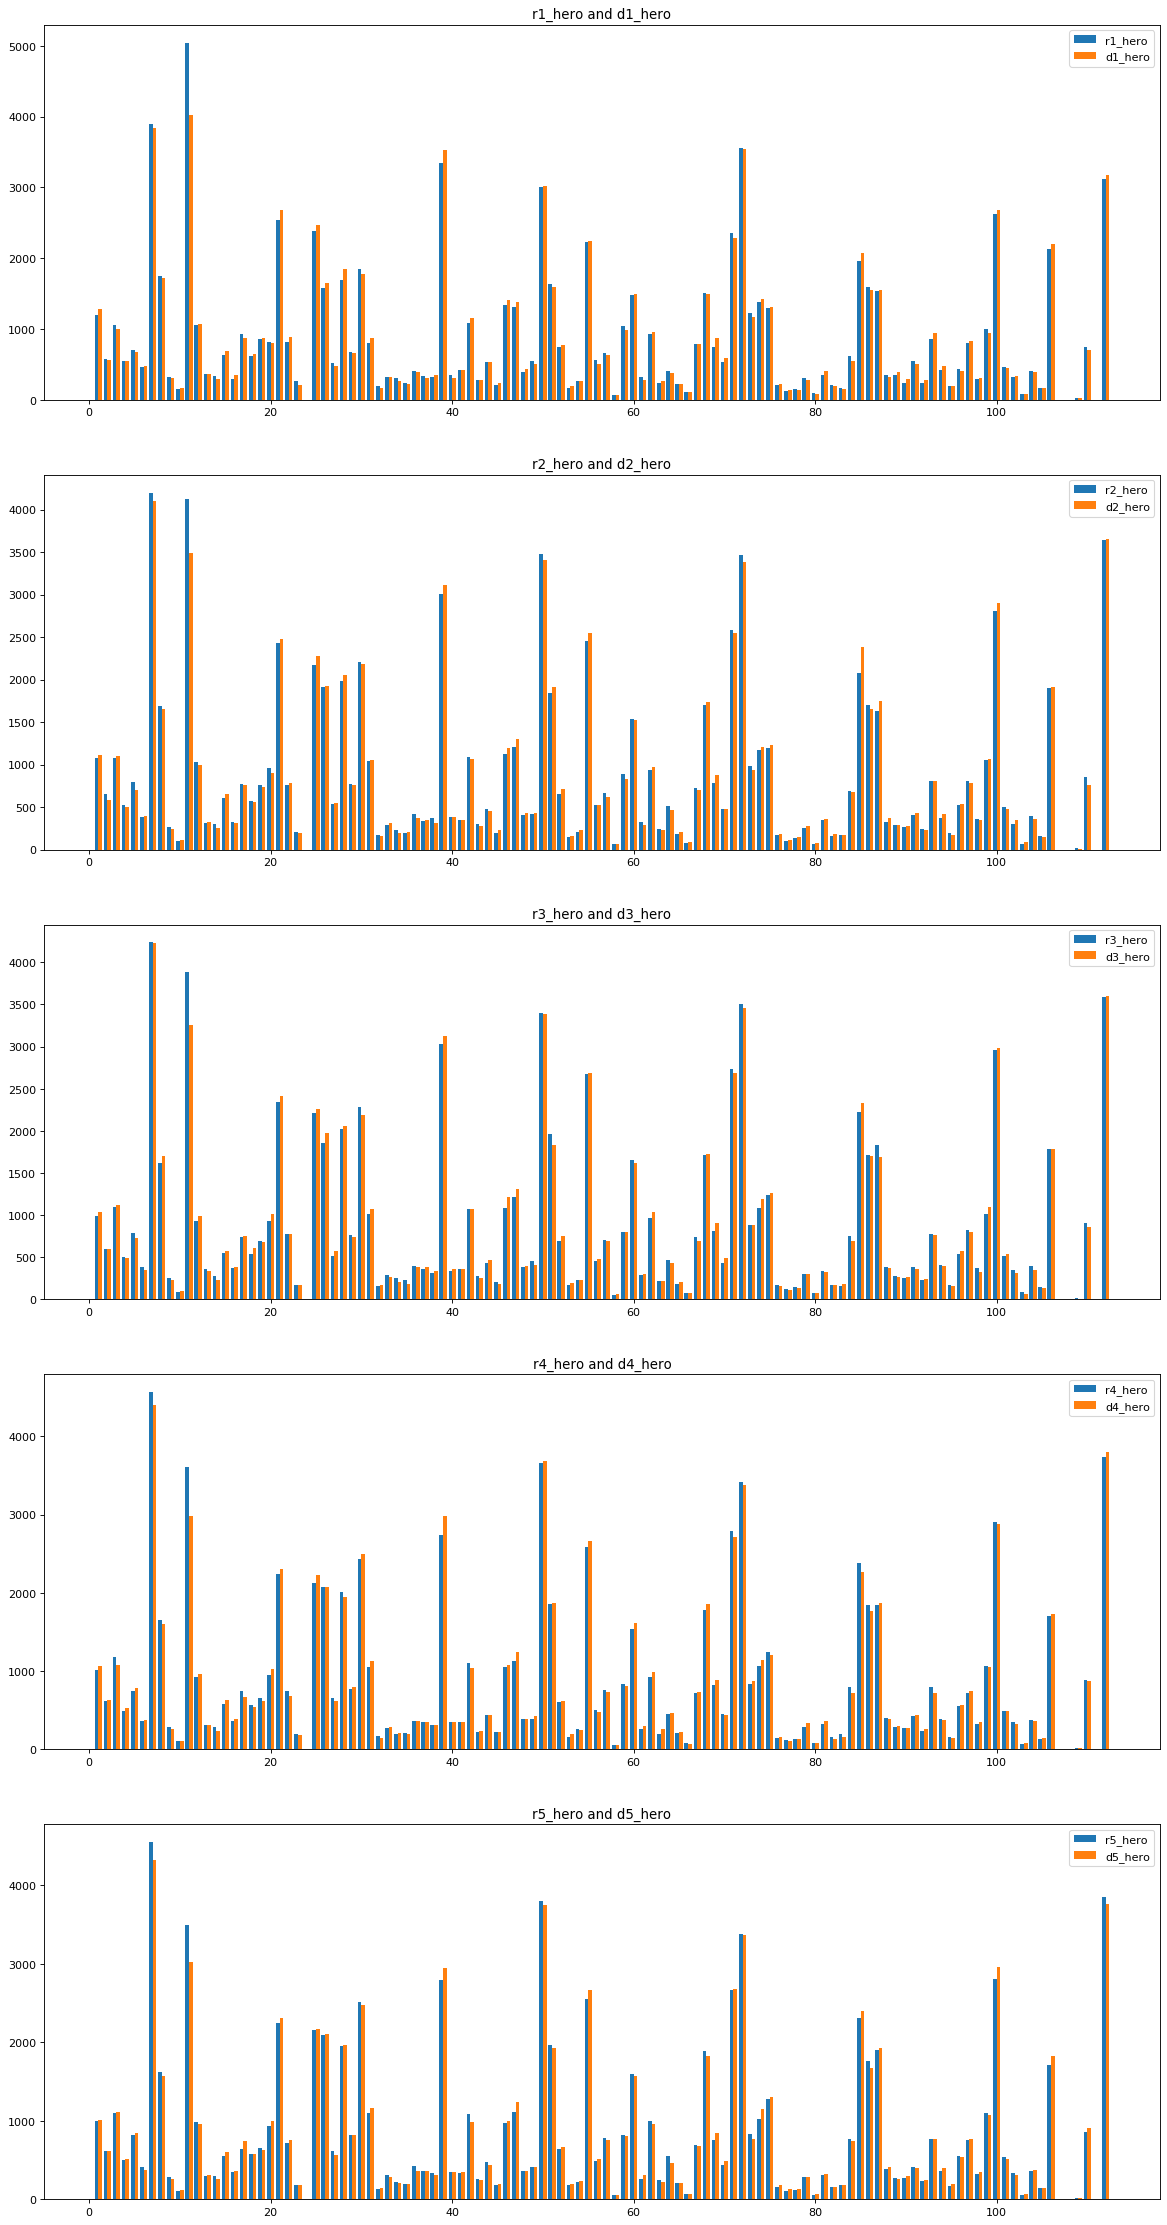

In [22]:
fig, axes = plt.subplots(5,1, figsize=(18, 36), dpi= 80, facecolor='w', edgecolor='k')

radiant = cat_features[:5]
dier = cat_features[5:]

for ax, r, d in zip(axes.flat, radiant, dier):
    ax.bar(data[r].value_counts().index - 0.2, data[r].value_counts().values, 
           label = r, 
           width = 0.4)
    ax.bar(data[d].value_counts().index + 0.2, data[d].value_counts().values, 
           label = d,
           width = 0.4)
    
    ax.set(title='{0} and {1}'.format(r, d))
    ax.legend()

print('id героя :', data['r1_hero'].unique())
print('-'*110)

plt.show()

Из данных графиков можно сделать вывод, что в зависимости от стороны, игроки чаще выбирают некоторых героев.

In [77]:
def hero_coder(data):

    X_pick = np.zeros((data.shape[0], 113))

    for i, match_id in enumerate(data.index):
        for p in range(1, 6):
            X_pick[i, data.loc[match_id, 'r%d_hero' % (p)]] = 1
            X_pick[i, data.loc[match_id, 'd%d_hero' % (p)]] = -1
            
    return X_pick

In [78]:
X_pick = hero_coder(data)

In [79]:
X_pick.shape

(97230, 113)

Данная матрица имеет 113 столбцов которые соответсвуют id героя. Несмотря на то, что героев 108 и номер героя не совпадает с его id в некоторых местах, будем использовать именно такие данные для удобства.

In [80]:
X_pick = scaler.fit_transform(X_pick)

In [81]:
X = np.concatenate((data_no_cat, X_pick), axis=1)

In [84]:
data_no_cat.shape

(97230, 91)

In [50]:
scores_lr = []

C = [10**i for i in range(-3,4)]

for c in C:
    lr_model = LogisticRegression(C=c, random_state=42)
    
    start_time = datetime.datetime.now()
    score_lr = cross_val_score(lr_model, X, labels, cv=fold, scoring='roc_auc', n_jobs=-1)
    
    scores_lr.append(score_lr.mean())
   
    print('Time elapsed for c = {0} : {1}'.format(c, datetime.datetime.now() - start_time))
    print('Score LR: ', score_lr)

Time elapsed for c = 0.001 : 0:00:08.546581
Score LR:  [0.74886777 0.75231215 0.74942961 0.7557793  0.7516747 ]
Time elapsed for c = 0.01 : 0:00:08.390902
Score LR:  [0.74934397 0.75315468 0.7495552  0.75609852 0.75166785]
Time elapsed for c = 0.1 : 0:00:08.168233
Score LR:  [0.74935103 0.7531731  0.74950394 0.75603359 0.75158849]
Time elapsed for c = 1 : 0:00:08.180083
Score LR:  [0.74934837 0.75317171 0.74949795 0.75602694 0.75158058]
Time elapsed for c = 10 : 0:00:08.274207
Score LR:  [0.74934869 0.75317207 0.74949823 0.75602538 0.75157939]
Time elapsed for c = 100 : 0:00:07.779174
Score LR:  [0.74934846 0.75317182 0.74949812 0.75602545 0.75157917]
Time elapsed for c = 1000 : 0:00:07.726674
Score LR:  [0.74934847 0.75317178 0.74949808 0.75602537 0.75157923]


Text(0, 0.5, 'Mean cross_val_score')

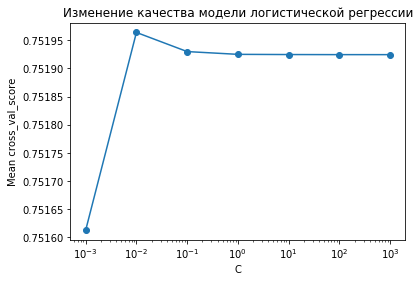

In [51]:
plt.xscale('log')
plt.plot(C, scores_lr, marker='o')
plt.title('Изменение качества модели логистической регрессии')
plt.xlabel('C')
plt.ylabel('Mean cross_val_score')

Можно заметить, что при полноценном использовании категориальных признаков качество модели увеличилось. Коофициент регуляризации при этом не изменился: наилучшее качество достигается при c = 10^-2.
Это можно объяснить тем, что теперь данные признаки стали более значимыми для классификатора. Теперь алгоритм смотрит именно на наличие/отстутствие того или иного героя в матче, а не пытается получить закономерности исходя из числа которое является идентификатором.

## Использование наилучшей модели

In [52]:
best_model = LogisticRegression(C=0.01, random_state=42)
best_model.fit(X, labels)

D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [99]:
test_data = pd.read_csv('D:/Downloads/features_test.csv', index_col='match_id')

In [100]:
cat_features = ['lobby_type']
for team in ['r', 'd']:
    for player in range(1,6):
        cat_features.append('{0}{1}_hero'.format(team, str(player)))

In [101]:
test_data.fillna(0, inplace=True)

In [102]:
test_no_cat = test_data.drop(cat_features, axis=1)

In [103]:
test_no_cat = scaler.fit_transform(test_no_cat)

D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Programs\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [104]:
X_pick_test = hero_coder(test_data)
X_test = np.concatenate((test_no_cat, X_pick_test), axis=1)

In [114]:
preds = best_model.predict_proba(X_test)[:,1]

In [115]:
print('Минимальное значение прогноза на тестовой выборке: ', preds.min())
print('Максимальное значение прогноза на тестовой выборке: ', preds.max())

Минимальное значение прогноза на тестовой выборке:  0.006629274201728231
Максимальное значение прогноза на тестовой выборке:  0.9953641855166777
